In [0]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = False, transform = transform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 20, shuffle = True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testset, batch_size = 20, shuffle = True, num_workers = 0)

0it [00:00, ?it/s]

9920512it [00:01, 8077451.64it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135927.57it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2215035.37it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50655.74it/s]            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


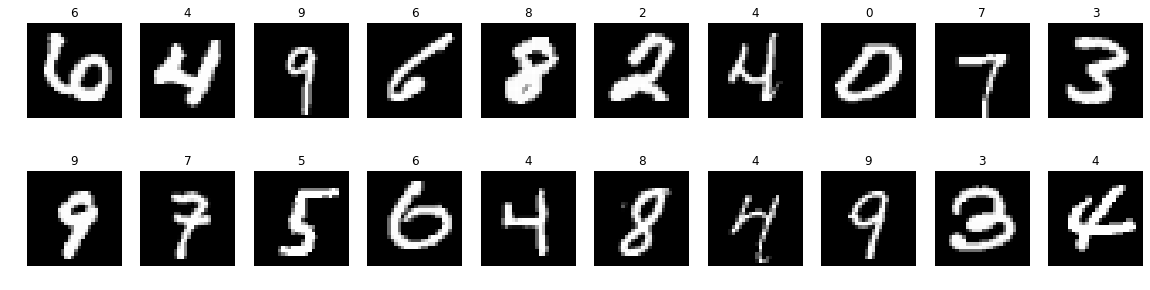

In [0]:
import numpy as np
import matplotlib.pyplot as plt

data = iter(trainLoader)
images, labels = data.next()
images = images.numpy()

fig = plt.figure(figsize = (20, 5))
for img in range(20):
  ax = fig.add_subplot(2, 10, img + 1)
  ax.imshow(np.squeeze(images[img]), cmap = 'gray')
  ax.set_title(str(labels[img].item()))
  ax.axis('off')

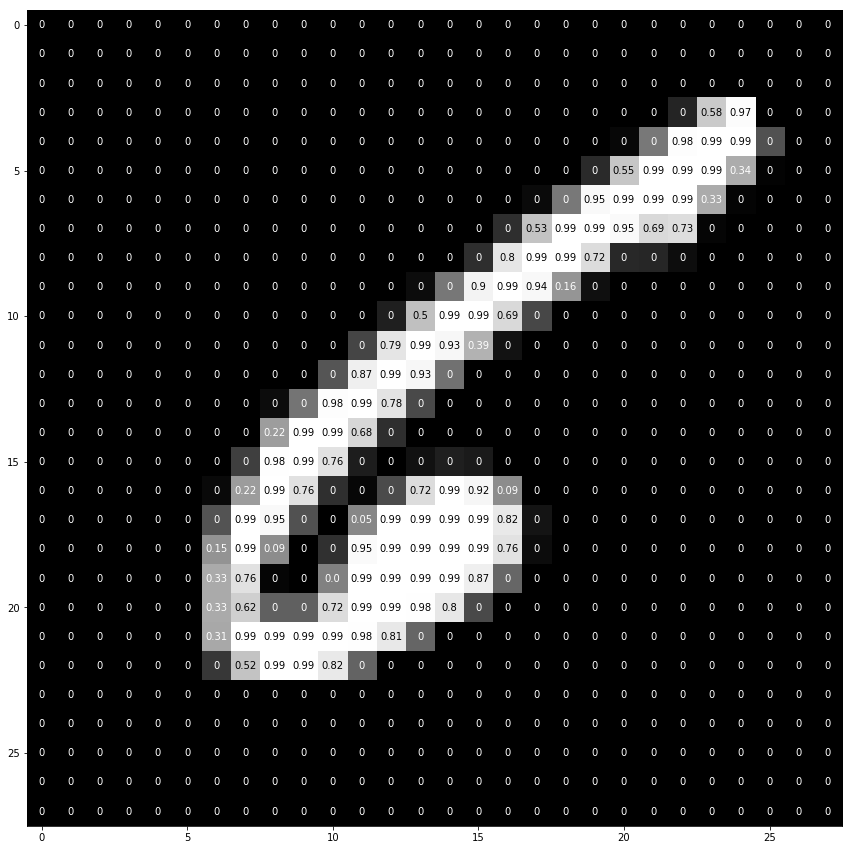

In [0]:
img = np.squeeze(images[3])
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = 'gray')
width, height = img.shape
thresh = img.max()/2.5
for i in range(width):
  for j in range(height):
    val = round(img[i][j], 2) if img[i][j] > 0 else 0
    ax.annotate(str(val), xy = (j, i),
               horizontalalignment = 'center',
               verticalalignment = 'center',
               color = 'white' if img[i][j] < thresh else 'black')

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.fc1 = nn.Linear(784, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 10)
    self.dropout = nn.Dropout(p = 0.2)
    
  def forward(self, x):
    x = x.view(images.shape[0], -1)
    
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.log_softmax(self.fc3(x), dim = 1)
    return x

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

epochs = 50
train_loss, test_loss = [], []
for e in range(epochs):
  model.train()
  trainloss = 0
  for images, labels in trainLoader:
    optimizer.zero_grad()
    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    trainloss += loss.item()
  else:
    testloss, accuracy = 0, 0
    with torch.no_grad():
      model.eval()
      for images, labels in testLoader:
        ps = torch.exp(model(images))
        top_ps, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        testloss += criterion(model(images), labels).item()
      model.train()
      train_loss.append(trainloss/len(trainLoader))
      test_loss.append(testloss/len(testLoader))
      print("Epoch {}/{}".format(e + 1, epochs),
           "Train loss {:.3f}".format(trainloss/len(trainLoader)),
           "Validation loss {:.3f}".format(testloss/len(testLoader)),
           "Accuracy {:.3f}".format((accuracy/len(testLoader)) * 100))

Epoch 1/50 Train loss 1.129 Validation loss 0.641 Accuracy 81.930
Epoch 2/50 Train loss 1.043 Validation loss 0.626 Accuracy 81.240
Epoch 3/50 Train loss 1.041 Validation loss 0.691 Accuracy 79.480
Epoch 4/50 Train loss 1.025 Validation loss 0.600 Accuracy 82.490
Epoch 5/50 Train loss 1.137 Validation loss 0.688 Accuracy 82.140
Epoch 6/50 Train loss 1.179 Validation loss 0.741 Accuracy 79.470


In [0]:
dataiter = iter(testLoader)
images, labels = dataiter.next()
ps = model(images)
top_ps, top_class = ps.topk(1, dim = 1)
images = images.numpy()
fig = plt.figure(figsize = (25, 4))
for img in range(20):
  ax = fig.add_subplot(2, 10, img + 1)
  ax.imshow(np.squeeze(images[img]), cmap = 'gray')
  ax.axis('off')
  ax.set_title("{0} ({1})".format(str(top_class[img].item()), str(labels[img].item())),
              color = "green" if top_class[img] == labels[img] else "red", fontsize = 18)